In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
import json
from collections import OrderedDict
import tensorflow as tf
import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from matplotlib import cm

In [6]:
from agnfinder.tf_sampling import deep_emulator, api, run_sampler
from agnfinder.tf_sampling.api import SamplingProblem
from agnfinder.tf_sampling.hmc import SamplerHMC
from agnfinder import simulation_utils, simulation_samples
from agnfinder.prospector import visualise, main, cpz_builders

Using TensorFlow backend.


In [7]:
tf.enable_eager_execution()

In [8]:
os.chdir('/home/mike/repos/agnfinder')

### Boilerplate to get the 'true' FSPS forward model

In [25]:
catalog_loc = '/media/mike/beta/agnfinder/cpz_paper_sample_week3.parquet'
free_params = OrderedDict({
    'log_mass': [8, 12], 
    'dust2': [0., 2.],  # not age of universe, as mistakenly done before...
    'tage': [0.001, 13.8],  # not 0->2, as mistakenly done before...might consider bringing the bounds a bit tighter
    'log_tau': [np.log10(.1), np.log10(30)],  # careful, this is log prior! >2, has very little effect
    'log_agn_mass': [-7, np.log10(15)],  # i.e. from 10**-7 to 15 (not 10**15!)
    'agn_eb_v': [0., 0.5],
    'log_agn_torus_mass': [-7, np.log10(15)]
})

In [26]:
forward_model, wavelengths = simulation_samples.get_forward_model(catalog_loc, emulate_ssp=False, noise=False)

[<class 'sedpy.observate.Filter'>(u_sloan), <class 'sedpy.observate.Filter'>(g_sloan), <class 'sedpy.observate.Filter'>(r_sloan), <class 'sedpy.observate.Filter'>(i_sloan), <class 'sedpy.observate.Filter'>(z_sloan), <class 'sedpy.observate.Filter'>(VISTA_H), <class 'sedpy.observate.Filter'>(VISTA_J), <class 'sedpy.observate.Filter'>(VISTA_Ks), <class 'sedpy.observate.Filter'>(VISTA_Y), <class 'sedpy.observate.Filter'>(VISTA_Z), <class 'sedpy.observate.Filter'>(wise_w1), <class 'sedpy.observate.Filter'>(wise_w2)]


### Load emulator

In [9]:

checkpoint_dir = 'results/checkpoints/hyperband_15_epochs'
new_emulator = False

In [10]:
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_dir, new=new_emulator)

### Load simulated galaxy observation/params from hypercube

In [11]:
_, _, x_test, y_test = deep_emulator.data()
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.float32)


In [65]:
galaxy_n = 5
true_params = x_test[galaxy_n]
true_observation = deep_emulator.denormalise_photometry(y_test[galaxy_n])

In [66]:
problem = SamplingProblem(true_observation, true_params, forward_model=emulator)

In [67]:
params = ['mass', 'dust2', 'tage', 'tau', 'agn_disk_scaling', 'agn_eb_v', 'agn_torus_scaling']

test_figure_dir = 'tests/test_figures'
true_params_2d = tf.reshape(problem.true_params, (1, 7))
predicted_photometry = deep_emulator.denormalise_photometry(problem.forward_model(true_params_2d)).numpy().reshape(-1, 1)


In [68]:
predicted_photometry

array([[1.7122089e-09],
       [5.3145297e-09],
       [1.3289582e-08],
       [1.9614243e-08],
       [2.7095346e-08],
       [4.4234586e-08],
       [4.0323695e-08],
       [4.7049600e-08],
       [3.4095997e-08],
       [2.6211499e-08],
       [2.5534501e-08],
       [1.7459701e-08]], dtype=float32)

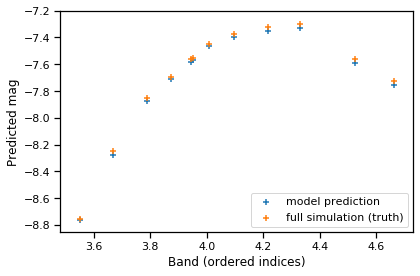

In [78]:

plt.figure()
plt.scatter(np.log10(wavelengths), np.log10(predicted_photometry), label='model prediction', marker='+')
plt.scatter(np.log10(wavelengths), np.log10(problem.true_observation), label='full simulation (truth)', marker='+')
plt.xlabel('Band (ordered indices)')
plt.ylabel('Predicted mag')
plt.legend()
plt.tight_layout()
# plt.savefig(os.path.join(test_figure_dir, 'model_vs_sim_at_logp_test_case.png'))


### Load actual samples

In [161]:
galaxy_loc = 'results/emulated_sampling/latest_6000_96_roughly_correct/galaxy_{}_performance.h5'.format(galaxy_n)
# galaxy_loc = 'results/emulated_sampling/latest_6000_96_random/galaxy_{}_performance.h5'.format(galaxy_n)

In [162]:
samples, _, _ = run_sampler.read_h5(galaxy_loc)

In [163]:
selected_indices = np.random.choice(range(len(samples)), 100)


In [164]:
selected_samples = samples[selected_indices, 2, :]  # only one chain

# Visualise SED of Samples and True Theta for either FSPS or Emulator

In [165]:
traces = deep_emulator.denormalise_photometry(problem.forward_model(selected_samples))

In [166]:
denormalised_samples = simulation_utils.denormalise_hypercube(selected_samples, free_params)

In [167]:
fsps_photometry = np.zeros((len(selected_samples), 12))
for n, sample in enumerate(denormalised_samples):
    p = forward_model(sample)
    fsps_photometry[n] = p

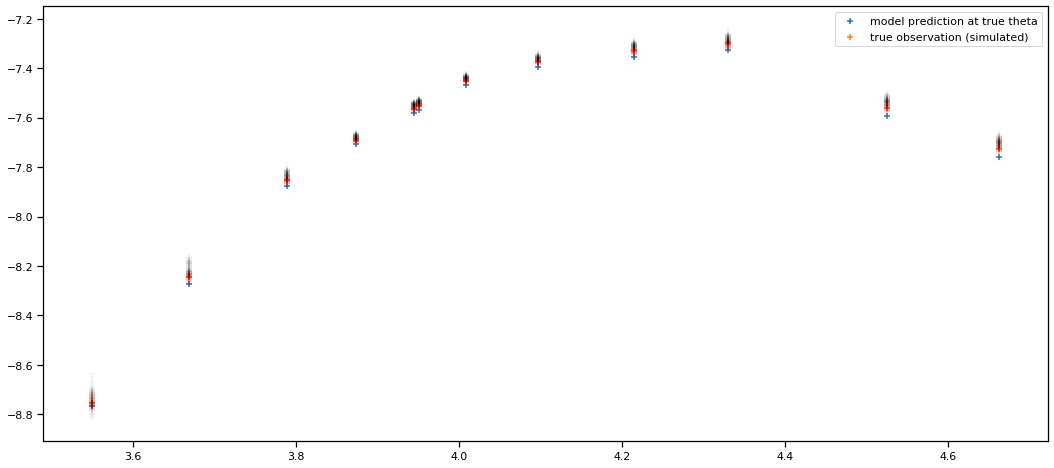

In [168]:
plt.figure(figsize=(18, 8))
plt.scatter(np.log10(wavelengths), np.log10(predicted_photometry), label='model prediction at true theta', marker='+')
plt.scatter(np.log10(wavelengths), np.log10(problem.true_observation), label='true observation (simulated)', marker='+')
for trace in traces:
    plt.scatter(np.log10(wavelengths), np.log10(trace), color='r', marker='+', alpha=0.02)
for photometry in fsps_photometry:
    plt.scatter(np.log10(wavelengths), np.log10(photometry), color='k', marker='+', alpha=0.02)
plt.legend()

Two observations:
- according to emulator, expected photometry is bang on the observed photometry
- putting those traces back through FSPS for the true expected photometry, you get another error ~ emulator error

In [169]:
forward_model(denormalised_samples[0])

array([2.01687244e-09, 6.87037213e-09, 1.59599053e-08, 2.22077253e-08,
       3.02717759e-08, 4.90223661e-08, 4.43271583e-08, 5.15920768e-08,
       3.74470662e-08, 2.94846506e-08, 2.90170233e-08, 1.97632095e-08])

In [170]:
dusts = np.linspace(0.2, 1.8)
photometry_with_dust = np.zeros((len(dusts), 12))
for n, dust in enumerate(dusts):
    theta = denormalised_samples[0]
    theta[2] = dust
    actual_p = forward_model(denormalised_samples[0])
    photometry_with_dust[n] = actual_p

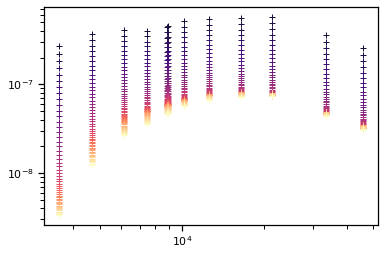

In [171]:
fig, ax = plt.subplots()
param_n = 0  # log mass
for n in range(len(photometry_with_dust)):
    ax.loglog(wavelengths, photometry_with_dust[n], marker='+', color=cm.magma(dusts[n]/1.8), linestyle='')
#     ax.set_title(param_names[param_n])

In [172]:
def get_python_log_prob_fn(fsps_forward_model, true_observation):
    def log_prob_fn(x):
        assert x.shape[1] == 7  # must have batch dimension
        denormalised_x = simulation_utils.denormalise_hypercube(x, free_params)
        expected_photometry = np.stack([fsps_forward_model(param_row) for param_row in denormalised_x], axis=0)
        deviation = np.abs(expected_photometry - true_observation)
        sigma = expected_photometry * 0.05  # i.e. 5% sigma, will read in soon-ish
        log_prob = -np.sum(deviation / sigma, axis=1)
        return log_prob
    return log_prob_fn


In [173]:
true_params.shape

(7,)

In [174]:
true_log_prob_fn = get_python_log_prob_fn(forward_model, problem.true_observation)

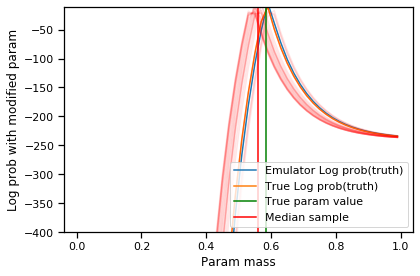

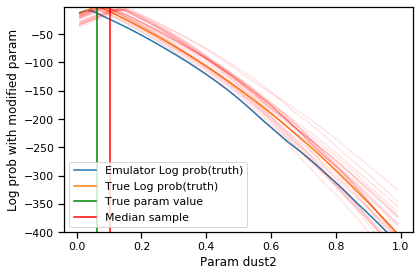

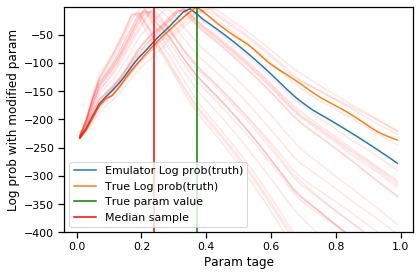

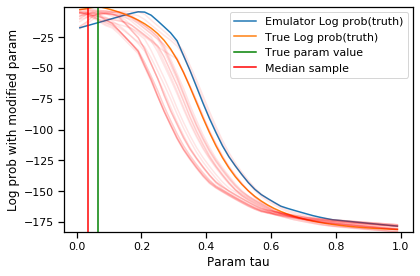

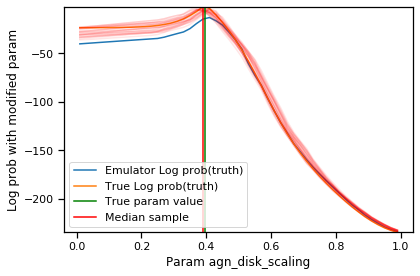

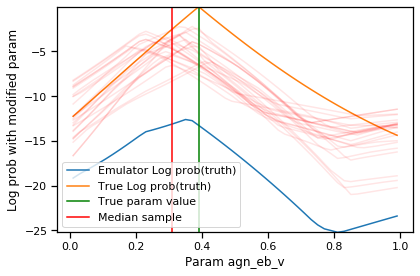

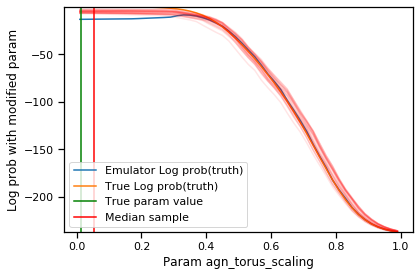

In [175]:

# look at slices of log prob, where one param varies (0, 1) and the rest are the true solution
# ideally, log prob is maximised in each case where the free param is near the true value
# might not always be true due to degeneracy, but should mostly be true
for param_n, param in enumerate(params):
    plt.figure()
    
    # range to vary one param
    param_values = np.linspace(0.01, 0.99, 50)
    
    # will record all log probs
    emulator_log_prob_at_truth = np.zeros(len(param_values))
    n_sample_log_probs = 25
    emulator_log_prob_at_sample = np.zeros((n_sample_log_probs, len(param_values)))
    true_log_prob_at_truth = np.zeros_like(emulator_log_prob_at_truth)
#     true_log_prob_at_sample = np.zeros_like(emulator_log_prob_at_truth)
    
    # take the correct params and vary one param
    modified_from_true = np.stack([true_params for _ in range(len(param_values))])
    modified_from_true[:, param_n] = param_values
    # take a few random samples and vary one paramsssssssssssssssssssssssssss
    modified_from_sample = np.zeros((n_sample_log_probs, len(param_values), 7))
    for sample_n in range(n_sample_log_probs):
        base_sample = selected_samples[np.random.choice(len(selected_samples))]
        modified_from_sample[sample_n] = np.stack([base_sample for _ in range(len(param_values))])
        modified_from_sample[sample_n, :, param_n] = param_values  # change value of one parameter

    # find log prob of emulator or truth (simulator) around true params
    emulator_log_prob_fn = api.get_log_prob_fn(problem.forward_model, problem.true_observation, batch_dim=len(param_values))
    emulator_log_prob_at_truth = emulator_log_prob_fn(tf.Variable(modified_from_true)).numpy()
    true_log_prob_at_truth = true_log_prob_fn(modified_from_true)
    
    # find log prob of emulator or truth (simulator) around samples
    for sample_n in range(n_sample_log_probs):
        theta = modified_from_sample[sample_n].astype(np.float32)
        emulator_log_prob_at_sample[sample_n] = emulator_log_prob_fn(tf.Variable(theta)).numpy()
#         true_log_prob_at_sample[n] = true_log_prob_fn(modified_from_sample)
  
    plt.plot(param_values, emulator_log_prob_at_truth, label='Emulator Log prob(truth)')

    plt.plot(param_values, true_log_prob_at_truth, label='True Log prob(truth)')
    for sample_n in range(n_sample_log_probs):
        plt.plot(param_values, emulator_log_prob_at_sample[sample_n], alpha=0.1, color='r')
#     plt.plot(param_values, true_log_prob_at_sample, label='True Log prob(sample)')
    plt.xlabel(f'Param {param}')
    plt.ylabel('Log prob with modified param')
    lowest_logprob = np.min([true_log_prob_at_truth.min(), emulator_log_prob_at_truth.min(), emulator_log_prob_at_sample.min()])
#     lowest_logprob = np.min([true_log_prob_at_truth.min(), emulator_log_prob_at_truth.min()])
    highest_logprob = np.max([true_log_prob_at_truth.max(), true_log_prob_at_truth.max()])
    lower_lim = np.max([-400, lowest_logprob])
    upper_lim = np.min([0, highest_logprob])
    plt.ylim([lower_lim, upper_lim])
    
    plt.axvline(true_params_2d[0, param_n].numpy(), c='g', label='True param value')
    plt.axvline(np.median(selected_samples[:, param_n]), c='r', label='Median sample')
    
    
    # let's also calculate the log prob, according to emulator, at each sample
#     selected_sample = selected_samples[np.random.choice(len(selected_samples), size=100, replace=False)]
#     selected_log_probs = emulator_log_prob_fn(tf.Variable(selected_sample)).numpy()
#     for sample_n, sample in enumerate(selected_sample):
#         plt.axvline(sample[param_n], c='k', alpha=0.1)
#         plt.scatter(sample[param_n], selected_log_probs[sample_n] , marker='+', color='r')
    plt.legend()
    plt.tight_layout()
#    plt.savefig(os.path.join(test_figure_dir, 'log_prob_modified_param_{}.png'.format(param_index)))


The emulator does a good job at copying the true likelihood (definitely near the truth, and presumably elsewhere as well)
The HMC does a good job at taking samples where the apparent likelihood is high

When the samples are otherwise quite close to the true solution, the likelihood slices of each sample are similar to the likelihood slices around the truth (as they ought to be).
But when the samples are not near the true solution, the slices for some parameters (correctly, I suppose) look very different around those 'other' theta